In [43]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import pennylane as qml
from torchvision import datasets, transforms
from torchsummary import summary


### Data Loading and Data Exploration 

Training data shape: torch.Size([12000, 28, 28])
Test data shape: torch.Size([2000, 28, 28])


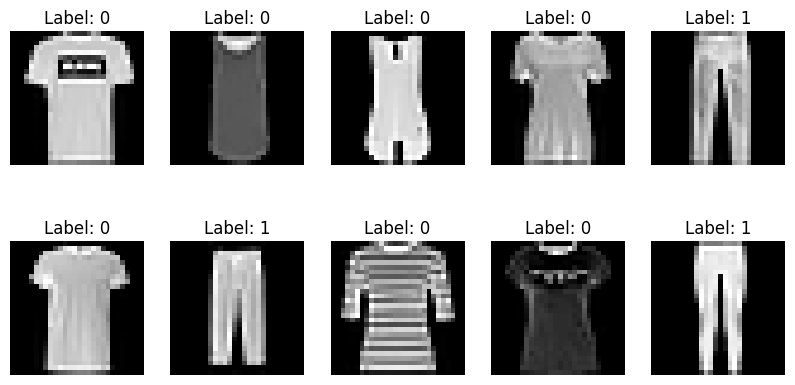

Shape of an individual training image: torch.Size([28, 28])
Shape of an individual test image: torch.Size([28, 28])
Class distribution in training set: [6000 6000]
Class distribution in test set: [1000 1000]


In [30]:
# Modifiying the MNIST Fashion for Binary Classification

# Define the transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Filter the dataset to keep only T-shirt/top (class 0) and Trouser (class 1)
train_indices = (train_dataset.targets == 0) | (train_dataset.targets == 1)
test_indices = (test_dataset.targets == 0) | (test_dataset.targets == 1)

train_data = train_dataset.data[train_indices]
train_targets = train_dataset.targets[train_indices]
test_data = test_dataset.data[test_indices]
test_targets = test_dataset.targets[test_indices]

# Convert targets to binary values
train_targets = train_targets.float()
test_targets = test_targets.float()

# Print the shape of the datasets
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Visualize some sample images from the training set
def plot_sample_images(images, labels, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {int(labels[i])}")
        ax.axis('off')
    plt.show()

# Plot 10 sample images
plot_sample_images(train_data, train_targets)

# Print the shape of an individual image before flattening
print(f"Shape of an individual training image: {train_data[0].shape}")
print(f"Shape of an individual test image: {test_data[0].shape}")

# Reshape data to add the channel dimension
train_data = train_data.unsqueeze(1).float()
test_data = test_data.unsqueeze(1).float()


# Create DataLoader
trainloader = DataLoader(TensorDataset(train_data, train_targets), batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(test_data, test_targets), batch_size=32, shuffle=False)



# Check class balance in the training set
train_labels = np.concatenate([labels.numpy() for _, labels in trainloader])
print(f"Class distribution in training set: {np.bincount(train_labels.astype(int))}")

# Check class balance in the test set
test_labels = np.concatenate([labels.numpy() for _, labels in testloader])
print(f"Class distribution in test set: {np.bincount(test_labels.astype(int))}")









### Defining the Quantum Layer and Model 

In [45]:
import torch
from torch import nn
import torch.nn.functional as F
import pennylane as qml

# Define the quantum device
dev = qml.device('default.qubit', wires=4)

# Define a quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(3, 4))  # 3 layers, 4 qubits

    def forward(self, x):
        # Applying the quantum node to each item in the batch
        # Use torch.stack to ensure the outputs are correctly shaped as a batch tensor
        q_out = [quantum_circuit(x[i], self.weights) for i in range(x.size(0))]
        return torch.stack([torch.tensor(i, dtype=torch.float32) for i in q_out]).to(x.device)

# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        quantum_input = x[:, :4]  # We're encoding the first 4 features
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification
'''

 # Define the hybrid network without the quantum layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification


'''


net = Net()


summary(net, (1, 28, 28))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
           Dropout-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
           Dropout-4                   [-1, 64]               0
      QuantumLayer-5                    [-1, 4]               0
            Linear-6                    [-1, 1]              69
Total params: 108,805
Trainable params: 108,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Training the model 

Starting training...
Epoch 1/20 - Loss: 0.5471971311569214
Epoch 2/20 - Loss: 0.5277187070846557
Epoch 3/20 - Loss: 0.5214715332984924
Epoch 4/20 - Loss: 0.5296064596970876
Epoch 5/20 - Loss: 0.5256065549850464
Epoch 6/20 - Loss: 0.5248337201277415
Epoch 7/20 - Loss: 0.5292269276777903
Epoch 8/20 - Loss: 0.5231482929388682
Epoch 9/20 - Loss: 0.5283040507634481
Epoch 10/20 - Loss: 0.5353365124861399
Epoch 11/20 - Loss: 0.5248947206338247
Epoch 12/20 - Loss: 0.5221652688185374
Epoch 13/20 - Loss: 0.5207788774967194
Epoch 14/20 - Loss: 0.5215728948116303
Epoch 15/20 - Loss: 0.525383535861969
Epoch 16/20 - Loss: 0.5287928709983826
Epoch 17/20 - Loss: 0.5263068195184072
Epoch 18/20 - Loss: 0.5217104980945587
Epoch 19/20 - Loss: 0.5201476314862569
Epoch 20/20 - Loss: 0.5208904604117076
Training completed in 9.239 seconds.


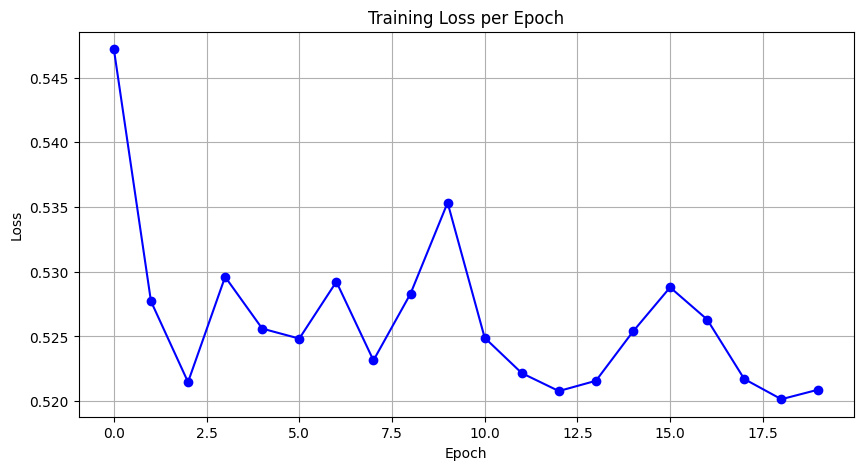

In [32]:
##This is the result from not using quantum layer

import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time

net = Net().to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 20
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        # Flatten Fashion MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(trainloader)}")
        losses.append(running_loss / len(trainloader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
'''
Accuracy: 0.963 # THIS IS for non quantum Training completed in 9.239 seconds.
Precision: 0.9832985386221295
Recall: 0.942
F1 Score: 0.9622063329928499'''


Starting training...
Epoch 1/20 - Loss: 0.543164799451828
Epoch 2/20 - Loss: 0.5286193664868672
Epoch 3/20 - Loss: 0.5306536340713501
Epoch 4/20 - Loss: 0.5259413700898489
Epoch 5/20 - Loss: 0.5257949315706889
Epoch 6/20 - Loss: 0.5276862941582998
Epoch 7/20 - Loss: 0.5325551228523254
Epoch 8/20 - Loss: 0.5340581006209055
Epoch 9/20 - Loss: 0.5296529983679453
Epoch 10/20 - Loss: 0.5276666467984518
Epoch 11/20 - Loss: 0.5233222045898438
Epoch 12/20 - Loss: 0.5256242337226867
Epoch 13/20 - Loss: 0.5209965100288391
Epoch 14/20 - Loss: 0.523640839656194
Epoch 15/20 - Loss: 0.522599162419637
Epoch 16/20 - Loss: 0.5232384726206462
Epoch 17/20 - Loss: 0.5249977227052053
Epoch 18/20 - Loss: 0.5198166918754578
Epoch 19/20 - Loss: 0.5229544563293457
Epoch 20/20 - Loss: 0.5202374610106151
Training completed in 1424.760 seconds.


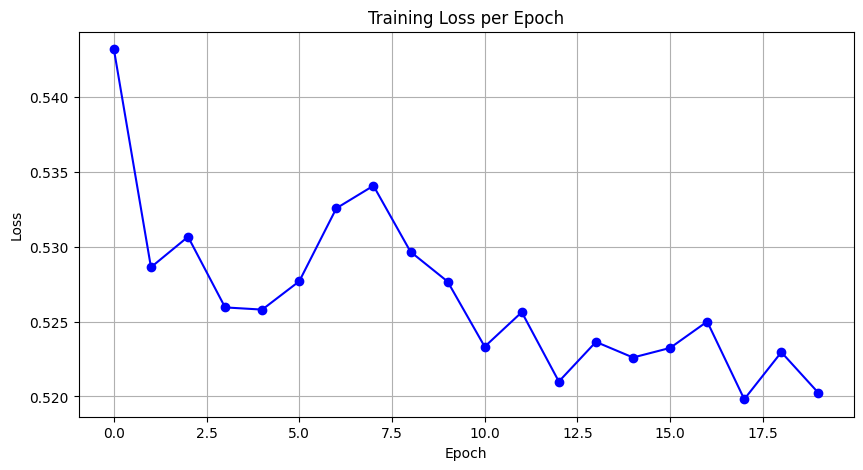

In [36]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time

net = Net().to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 20
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        # Flatten Fashion MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(trainloader)}")
        losses.append(running_loss / len(trainloader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



### Evaluation

Accuracy: 0.9615
Precision: 0.9863013698630136
Recall: 0.936
F1 Score: 0.9604925602873269


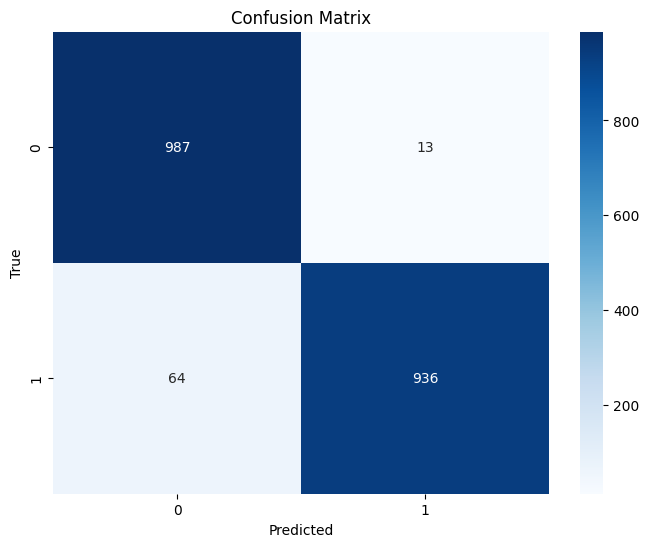

In [37]:


# Evaluation
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## The previous architecture only selected the first 4 features prior the quantum layer. In this part of the code, we Apply PCA to derive more important features: 

Fitting PCA on the Intermediate Output:

We first pass some training data through the Net class (up to the second fully connected layer) and fit PCA on this 64-dimensional output.
Creating the HybridNet Class:

The HybridNet class integrates the PCA transformation into the forward pass before the quantum layer.
Training Loop:

The training loop uses the HybridNet class for training and evaluation.




In [46]:
from sklearn.decomposition import PCA
import torch

# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x



# Instantiate the network
net = Net().to(device)

# Fit PCA on the output of the second fully connected layer
net.eval()
with torch.no_grad():
    outputs = []
    for images, _ in trainloader:
        images = images.to(device)
        images = images.view(images.shape[0], -1)
        outputs.append(net(images).cpu().numpy())
outputs = np.concatenate(outputs)
pca = PCA(n_components=4)
pca.fit(outputs)



# Define the hybrid quantum-classical class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after the first activation
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after the second activation
        quantum_input = x[:, :4]  # We're encoding the first 4 features
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification



# Define the final hybrid network with PCA transformation
class HybridNet(nn.Module):
    def __init__(self, pca):
        super(HybridNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.quantum_layer = QuantumLayer()
        self.fc3 = nn.Linear(64 + 4, 1)  # Output a single value for binary classification
        self.pca = pca

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Apply PCA to get the most important 4 features
        quantum_input = torch.tensor(self.pca.transform(x.detach().cpu().numpy()), dtype=torch.float32).to(x.device)
        quantum_output = self.quantum_layer(quantum_input)
        x = torch.cat([x, quantum_output], dim=1)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid for binary classification




# Instantiate the final network
hybrid_net = HybridNet(pca).to(device)
summary(hybrid_net, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
      QuantumLayer-3                    [-1, 4]               0
            Linear-4                    [-1, 1]              69
Total params: 108,805
Trainable params: 108,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


#### Now we repeat the training step and evaluation step  

Starting training...
Epoch 1/20 - Loss: 0.5297321925163269
Epoch 2/20 - Loss: 0.5192931723594666
Epoch 3/20 - Loss: 0.5222300218741099
Epoch 4/20 - Loss: 0.5206347195307414
Epoch 5/20 - Loss: 0.5270457447369893
Epoch 6/20 - Loss: 0.5185787136554718
Epoch 7/20 - Loss: 0.5234144509633382
Epoch 8/20 - Loss: 0.5207901258468628
Epoch 9/20 - Loss: 0.529054800748825
Epoch 10/20 - Loss: 0.5203762529691061
Epoch 11/20 - Loss: 0.5254858624140422
Epoch 12/20 - Loss: 0.5548356258869171
Epoch 13/20 - Loss: 0.5222898797194163
Epoch 14/20 - Loss: 0.527076366186142
Epoch 15/20 - Loss: 0.5251794300874074
Epoch 16/20 - Loss: 0.514097874323527
Epoch 17/20 - Loss: 0.5136959422429402
Epoch 18/20 - Loss: 0.5144367629686991
Epoch 19/20 - Loss: 0.5248473060131073
Epoch 20/20 - Loss: 0.5136377793947856
Training completed in 1342.414 seconds.


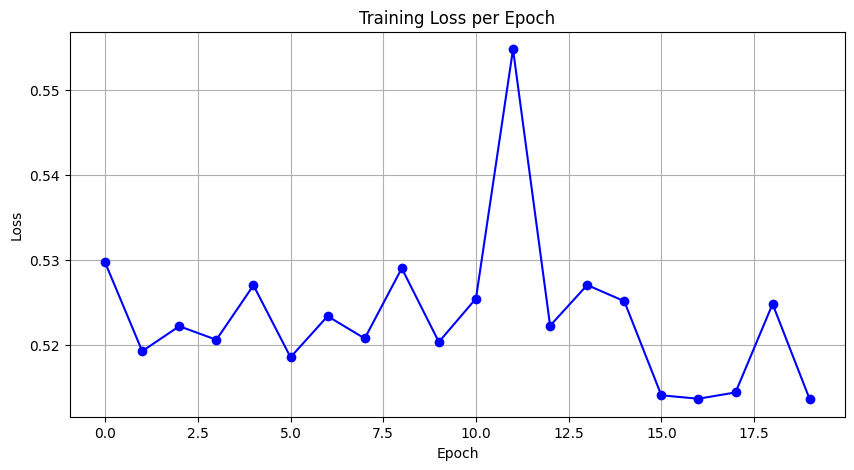

Accuracy: 0.9715
Precision: 0.9855818743563337
Recall: 0.957
F1 Score: 0.9710806697108066


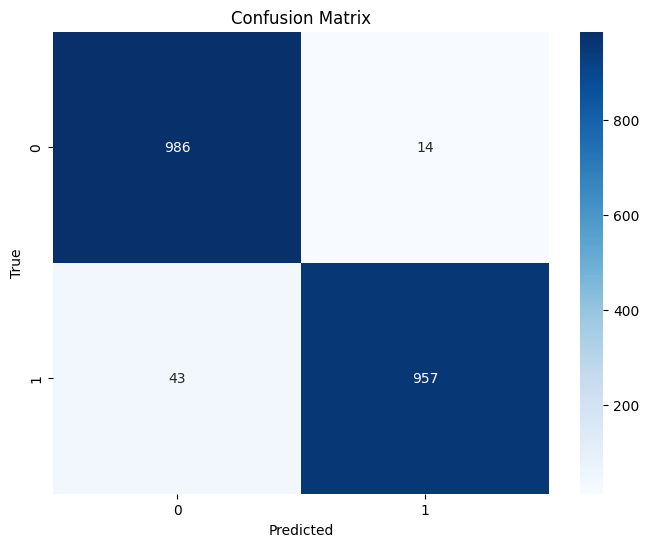

In [41]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hybrid_net.parameters(), lr=0.001)

# To keep track of the loss values
losses = []

# Training the network
epochs = 20
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = hybrid_net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss/len(trainloader)}")
        losses.append(running_loss / len(trainloader))

end_time = time.time()
print(f"Training completed in {end_time - start_time:.3f} seconds.")

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
hybrid_net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        outputs = hybrid_net(images)
        preds = torch.round(outputs)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [42]:
from torchsummary import summary
summary(model, (1, 28, 28))

NameError: name 'model' is not defined

In [20]:
#dEBUGGING

import numpy as np

# Check class balance in the training set
train_labels = np.concatenate([labels.numpy() for _, labels in trainloader])
print(f"Class distribution in training set: {np.bincount(train_labels.astype(int))}")

# Check class balance in the test set
test_labels = np.concatenate([labels.numpy() for _, labels in testloader])
print(f"Class distribution in test set: {np.bincount(test_labels.astype(int))}")


Class distribution in training set: [6000 6000]
Class distribution in test set: [1000 1000]


# FER-2013 BINARY 
1. Regular NN structure
2. Hybrid structure with pooling
3. Hybrid with PCA
4. Hybrid with Angle Encoding
5. Hybrid with MPS

### Data Loading and Data Exploration 